In [111]:
# ===============================================================
# 01 - EDA y Preprocesamiento del Dataset IPS
# ===============================================================

import os, re, pathlib, unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
pd.set_option("display.max_colwidth", 120)
sns.set(style="whitegrid", palette="pastel")

# ---------------------------------------------------------------
# Importar utilidades compartidas (centraliza lógica de paths)
# ---------------------------------------------------------------
try:
 from utils_shared import setup_paths, validate_file_exists
 paths = setup_paths()
 BASE_PATH = paths['BASE_PATH']
 DATA_PATH = paths['DATA_PATH']
 FIGS_PATH = paths['FIGS_PATH']
 print("[OK] Usando utils_shared.py para configuración de paths")
except ImportError:
 print("[WARNING] utils_shared.py no encontrado, usando configuración manual")
 BASE_PATH = pathlib.Path.cwd()
 if BASE_PATH.name == "notebooks":
    BASE_PATH = BASE_PATH.parent
 DATA_PATH = BASE_PATH / "data"
 FIGS_PATH = DATA_PATH / "figs"
 FIGS_PATH.mkdir(parents=True, exist_ok=True)

RAW_FILE = DATA_PATH / "ips_raw.csv"

print(f" BASE_PATH: {BASE_PATH}")
print(f" DATA_PATH: {DATA_PATH}")
print(f" FIGS_PATH: {FIGS_PATH}")
print(f" RAW_FILE: {RAW_FILE} (existe: {RAW_FILE.exists()})")

[OK] Usando utils_shared.py para configuración de paths
 BASE_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay
 DATA_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data
 FIGS_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs
 RAW_FILE: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/ips_raw.csv (existe: True)


In [112]:
# ===============================================================
# Carga de datos crudos
# ===============================================================
# Validar que el archivo exista antes de intentar cargar
if not RAW_FILE.exists():
 raise FileNotFoundError(
 f"[X] No se encontró ips_raw.csv en {DATA_PATH}\n"
 f" Verifica que el archivo esté en la ubicación correcta."
 )
 
df_raw = pd.read_csv(RAW_FILE)
print(f"[OK] Dataset cargado exitosamente")
print(f" Filas: {df_raw.shape[0]:,}")
print(f" Columnas: {df_raw.shape[1]}")
print(f" Columnas disponibles: {list(df_raw.columns)}")

df_raw.head()

[OK] Dataset cargado exitosamente
 Filas: 3,155
 Columnas: 10
 Columnas disponibles: ['Archivo', 'Prontuario', 'Nombre Paciente', 'Sexo', 'Fecha Nacimiento', 'N° Consulta', 'Id', 'Fecha Consulta', 'Motivo Consulta', 'Tipo']


,Archivo,Prontuario,Nombre Paciente,Sexo,Fecha Nacimiento,N° Consulta,Id,Fecha Consulta,Motivo Consulta,Tipo
0,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,1,1,16/05/2025,Reposicion de medicacion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEM...,ansiedad
1,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,2,1,14/04/2025,acude para reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEMPER...,ansiedad
2,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,3,1,19/03/2025,"Se encuentra estable, tranquila, refiere buen animo. Mejoria de sintomas Se encuentra estable, tranquila, refiere bu...",ansiedad
3,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,4,1,13/03/2025,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...,ansiedad
4,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,5,1,13/02/2025,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...,ansiedad


### ===============================================================
### Análisis a nivel de PACIENTES
### ===============================================================
### CRÍTICO: Dataset tiene estructura longitudinal (múltiples consultas por paciente)
### Este análisis es fundamental para diseñar splits sin data leakage

📊 ANÁLISIS DE ESTRUCTURA LONGITUDINAL
Pacientes únicos: 90
Casos totales (consultas): 3,155
Promedio casos/paciente: 35.1
Mediana casos/paciente: 34
Min-Max casos/paciente: 6-65

⚠️  IMPLICACIÓN PARA SPLITS:
   Con 35.1 casos/paciente, un split ALEATORIO
   por casos pondría el 100% de pacientes en train Y val
   → SOLUCIÓN: Split por PACIENTES (ver 02_create_splits.ipynb)

📈 Distribución de casos/paciente:
count    90.000000
mean     35.055556
std      11.647791
min       6.000000
25%      27.000000
50%      33.500000
75%      42.750000
max      65.000000
Name: count, dtype: float64


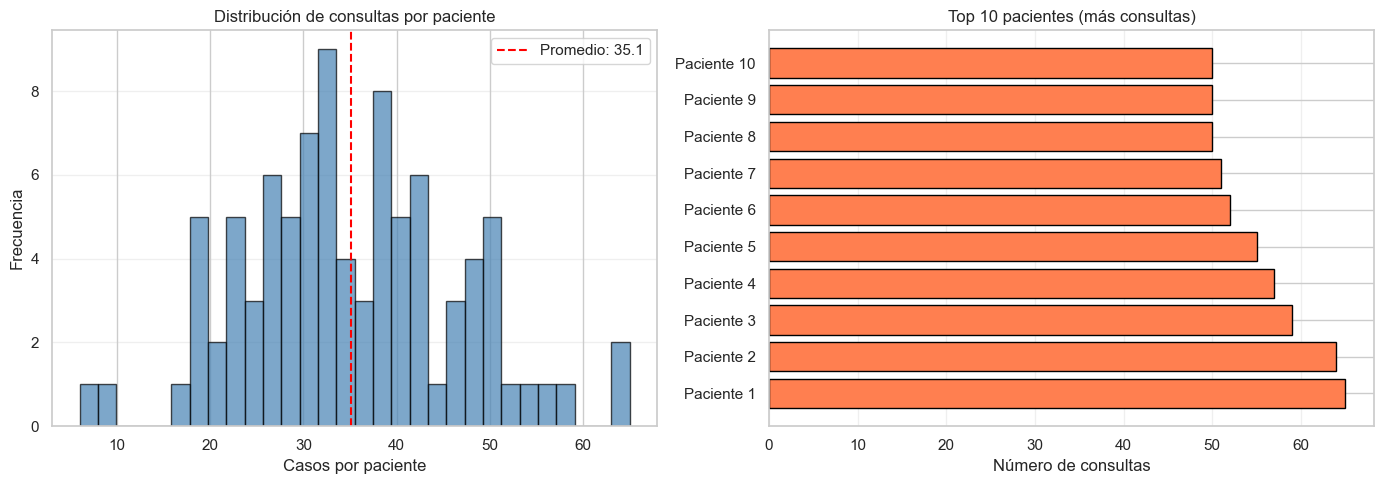


✅ Gráfico guardado en: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/eda_patient_distribution.png


In [ ]:
# ---------------------------------------------------------------
# Análisis de pacientes (estructura longitudinal)
# ---------------------------------------------------------------
# Esta métrica es CRÍTICA para entender la estructura del dataset:
# - Si hay pocos pacientes con muchas consultas → Alto riesgo de leakage
# - Split debe ser por PACIENTE (no por casos) para evitar leakage

PATIENT_COL = 'Prontuario'

if PATIENT_COL in df_raw.columns:
    n_patients = df_raw[PATIENT_COL].nunique()
    n_cases = len(df_raw)
    avg_cases_per_patient = n_cases / n_patients
    
    patient_counts = df_raw[PATIENT_COL].value_counts()
    
    print("="*60)
    print(" ANÁLISIS DE ESTRUCTURA LONGITUDINAL")
    print("="*60)
    print(f"Pacientes únicos: {n_patients}")
    print(f"Casos totales (consultas): {n_cases:,}")
    print(f"Promedio casos/paciente: {avg_cases_per_patient:.1f}")
    print(f"Mediana casos/paciente: {patient_counts.median():.0f}")
    print(f"Min-Max casos/paciente: {patient_counts.min()}-{patient_counts.max()}")
    
    print(f"\n  IMPLICACIÓN PARA SPLITS:")
    print(f"   Con {avg_cases_per_patient:.1f} casos/paciente, un split ALEATORIO")
    print(f"   por casos pondría el 100% de pacientes en train Y val")
    print(f"   → SOLUCIÓN: Split por PACIENTES (ver 02_create_splits.ipynb)")
    
    # Distribución de casos por paciente
    print(f"\n Distribución de casos/paciente:")
    print(patient_counts.describe())
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histograma
    axes[0].hist(patient_counts, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(avg_cases_per_patient, color='red', linestyle='--', 
                    label=f'Promedio: {avg_cases_per_patient:.1f}')
    axes[0].set_xlabel('Casos por paciente')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title('Distribución de consultas por paciente')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Top 10 pacientes con más consultas
    top10 = patient_counts.head(10)
    axes[1].barh(range(len(top10)), top10.values, color='coral', edgecolor='black')
    axes[1].set_yticks(range(len(top10)))
    axes[1].set_yticklabels([f"Paciente {i+1}" for i in range(len(top10))])
    axes[1].set_xlabel('Número de consultas')
    axes[1].set_title('Top 10 pacientes (más consultas)')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGS_PATH / 'eda_patient_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n Gráfico guardado en: {FIGS_PATH / 'eda_patient_distribution.png'}")
    
else:
    print(f"  WARNING: Columna '{PATIENT_COL}' no encontrada")
    print(f"   Columnas disponibles: {list(df_raw.columns)}")

In [114]:
# ---------------------------------------------------------------
# Auditoría inicial
# ---------------------------------------------------------------
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Archivo           3155 non-null   object
 1   Prontuario        3155 non-null   int64 
 2   Nombre Paciente   3155 non-null   object
 3   Sexo              3155 non-null   object
 4   Fecha Nacimiento  3155 non-null   object
 5   N° Consulta       3155 non-null   int64 
 6   Id                3155 non-null   int64 
 7   Fecha Consulta    3155 non-null   object
 8   Motivo Consulta   3148 non-null   object
 9   Tipo              3155 non-null   object
dtypes: int64(3), object(7)
memory usage: 246.6+ KB


In [115]:
# Nulos por columna
nulls = df_raw.isna().sum().sort_values(ascending=False)
display(nulls)

Motivo Consulta     7
Archivo             0
Prontuario          0
Nombre Paciente     0
Sexo                0
Fecha Nacimiento    0
N° Consulta         0
Id                  0
Fecha Consulta      0
Tipo                0
dtype: int64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


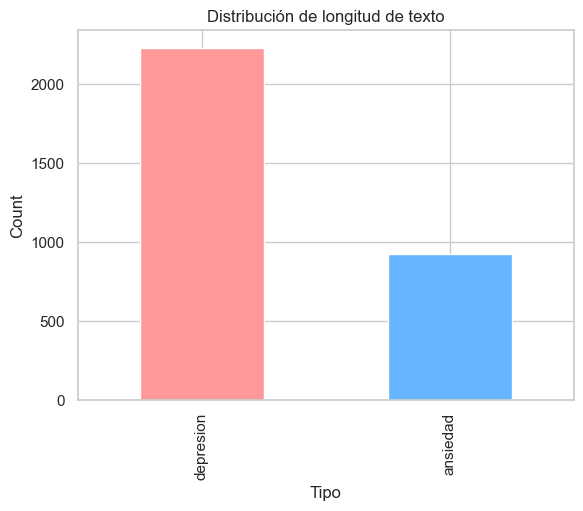

count     3155.000000
mean      1881.963233
std       2982.332377
min          3.000000
25%        461.000000
50%        765.000000
75%       2110.000000
max      32767.000000
Name: text_length, dtype: float64


In [116]:
# ---------------------------------------------------------------
# Distribución de etiquetas y longitud de texto
# ---------------------------------------------------------------
text_col = 'Motivo Consulta' if 'Motivo Consulta' in df_raw.columns else df_raw.columns[0]
if 'Tipo' in df_raw.columns:
 df_raw['Tipo'] = df_raw['Tipo'].str.lower().str.strip()
 df_raw['Tipo'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff'], title='Distribución de clases')

df_raw['text_length'] = df_raw[text_col].astype(str).apply(len)
sns.histplot(df_raw['text_length'], bins=30, kde=True)
plt.title("Distribución de longitud de texto")
plt.show()

print(df_raw['text_length'].describe())


In [117]:
# ===============================================================
# Limpieza de texto: Estrategia LIGERA para EDA
# ===============================================================
# Definimos función de limpieza LIGERA que será usada para generar
# ips_clean.csv. Esta estrategia es conservadora para no perder
# información importante durante el análisis exploratorio.
#
# Decisiones de diseño:
# 1. Mantener tildes (depresión ≠ depresion en análisis)
# 2. Mantener casing parcial (nombres propios, siglas)
# 3. Solo colapsar alargamientos obvios (holaaa → holaa)
# 4. Conservar puntuación básica (puede indicar estructura)
#
# Nota: Cada baseline aplicará su propio preprocesamiento después.

import re, unicodedata

# Regex para detectar alargamientos: 3+ caracteres iguales consecutivos
_RE_MULTI = re.compile(r'(.)\1{2,}')

def clean_text_eda(s: str) -> str:
 """
 Limpieza ligera de texto para EDA y exportación a ips_clean.csv.
 
 Transformaciones aplicadas:
 1. Normalización Unicode (NFC) - forma canónica
 2. Colapso de alargamientos: "holaaa" → "holaa"
 3. Remoción de caracteres especiales raros
 4. Compactación de espacios múltiples
 
 Lo que NO hace (intencionalmente):
 - NO lowercase (conserva casing)
 - NO remueve tildes (conserva diacríticos)
 - NO remueve puntuación básica
 - NO tokeniza ni lematiza
 """
 if pd.isna(s): 
    return ""
 
 s = str(s).strip()
 
 # Normalización Unicode a forma canónica compuesta (tildes compuestas)
 s = unicodedata.normalize("NFC", s)
 
 # Colapsar alargamientos: "ansiedaaaad" → "ansiedaad"
 # Dejamos 2 repeticiones porque pueden ser legítimas ("lleego", "arriba")
 s = _RE_MULTI.sub(r'\1\1', s)
 
 # Remover caracteres extraños pero conservar:
 # - Letras (con tildes): A-Z, a-z, áéíóúüñÁÉÍÓÚÜÑ
 # - Dígitos: 0-9
 # - Espacios y tabs
 # - Puntuación básica: . , ; : ! ? ( ) - / % +
 s = re.sub(r"[^0-9A-Za-zÁÉÍÓÚÜÑáéíóúüñ \t\n\r.,;:!?()\-/%+]", " ", s)
 
 # Compactar espacios múltiples a uno solo
 s = re.sub(r"\s+", " ", s).strip()
 
 return s

# Aplicar limpieza al dataset
df_raw['text_clean'] = df_raw[text_col].apply(clean_text_eda)

# Mostrar ejemplos del antes/después
print(" Ejemplos de limpieza (primeros 3):")
print("="*80)
for i in range(min(3, len(df_raw))):
 original = str(df_raw[text_col].iloc[i])[:60]
 cleaned = str(df_raw['text_clean'].iloc[i])[:60]
 print(f"{i+1}. Original: {original}...")
 print(f" Limpio: {cleaned}...")
 print()

df_raw[[text_col, 'text_clean']].head()

 Ejemplos de limpieza (primeros 3):
1. Original: Reposicion de medicacion 2) EXAMEN FISICO GRAL. Y GINECOLOGI...
 Limpio: Reposicion de medicacion 2) EXAMEN FISICO GRAL. Y GINECOLOGI...

2. Original: acude para reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO ...
 Limpio: acude para reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO ...

3. Original: Se encuentra estable, tranquila, refiere buen animo. Mejoria...
 Limpio: Se encuentra estable, tranquila, refiere buen animo. Mejoria...



,Motivo Consulta,text_clean
0,Reposicion de medicacion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEM...,Reposicion de medicacion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEM...
1,acude para reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEMPER...,acude para reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEMPER...
2,"Se encuentra estable, tranquila, refiere buen animo. Mejoria de sintomas Se encuentra estable, tranquila, refiere bu...","Se encuentra estable, tranquila, refiere buen animo. Mejoria de sintomas Se encuentra estable, tranquila, refiere bu..."
3,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...
4,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...


In [118]:
# Longitudes
df_raw["len_text"] = df_raw[text_col].astype(str).str.len()
df_raw["len_tokens_approx"] = df_raw[text_col].astype(str).str.split().map(len)
display(df_raw["len_text"].describe())
display(df_raw["len_tokens_approx"].describe())

count     3155.000000
mean      1881.963233
std       2982.332377
min          3.000000
25%        461.000000
50%        765.000000
75%       2110.000000
max      32767.000000
Name: len_text, dtype: float64

count    3155.000000
mean      311.579715
std       503.777358
min         1.000000
25%        72.000000
50%       126.000000
75%       348.000000
max      5946.000000
Name: len_tokens_approx, dtype: float64

In [119]:
# ---------------------------------------------------------------
# Duplicados (CRÍTICO para comparabilidad de baselines)
# ---------------------------------------------------------------
# Eliminar duplicados exactos en texto limpio
duplicates = df_raw.duplicated(subset=['text_clean'], keep='first')
print(f" Duplicados exactos encontrados: {duplicates.sum()} / {len(df_raw)}")
print(f" Proporción: {100*duplicates.sum()/len(df_raw):.2f}%")

# Mantener solo primera ocurrencia
df_clean = df_raw[~duplicates].copy().reset_index(drop=True)
print(f"\n[OK] Dataset sin duplicados: {df_clean.shape}")
print(f" Eliminados: {len(df_raw) - len(df_clean)} registros")

# Verificación
if df_clean.duplicated(subset=['text_clean']).sum() > 0:
 print("[WARNING] WARNING: Aún hay duplicados!")
else:
 print("[OK] Verificado: No hay duplicados restantes")

# Mostrar ejemplos de duplicados eliminados (opcional)
if duplicates.sum() > 0:
    print("\n Ejemplos de textos duplicados (mostrando primeros 3):")
    dup_texts = df_raw[duplicates]['text_clean'].head(3).tolist()
    for i, txt in enumerate(dup_texts, 1):
        print(f" {i}. {txt[:80]}...")

 Duplicados exactos encontrados: 28 / 3155
 Proporción: 0.89%

[OK] Dataset sin duplicados: (3127, 14)
 Eliminados: 28 registros
[OK] Verificado: No hay duplicados restantes

 Ejemplos de textos duplicados (mostrando primeros 3):
 1. Acude sin cita para consulta de urgenca debido a que desde ayer esta en Acude si...
 2. ACUDE A RETIRAR MEDICACION ACUDE A RETIRAR MEDICACION REPOSICION DE MEDICACION D...
 3. retira medicación 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESI...


In [120]:
# ---------------------------------------------------------------
# Columnas finales y normalización
# ---------------------------------------------------------------
cols = ['Id', 'Fecha Consulta', 'Tipo', 'text_clean']
df_final = df_clean[cols].copy() if all(c in df_clean.columns for c in cols) else df_clean.copy()

df_final = df_final.rename(columns={
 'Id': 'id_paciente',
 'Tipo': 'etiqueta',
 'Fecha Consulta': 'fecha',
 'text_clean': 'texto'
})
df_final['etiqueta'] = df_final['etiqueta'].str.lower().str.strip()

print("Columnas finales:", df_final.columns.tolist())
df_final.head()


Columnas finales: ['id_paciente', 'fecha', 'etiqueta', 'texto']


,id_paciente,fecha,etiqueta,texto
0,1,16/05/2025,ansiedad,Reposicion de medicacion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEM...
1,1,14/04/2025,ansiedad,acude para reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEMPER...
2,1,19/03/2025,ansiedad,"Se encuentra estable, tranquila, refiere buen animo. Mejoria de sintomas Se encuentra estable, tranquila, refiere bu..."
3,1,13/03/2025,ansiedad,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...
4,1,13/02/2025,ansiedad,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...


Distribución de clases:
etiqueta
depresion    2202
ansiedad      925
Name: count, dtype: int64


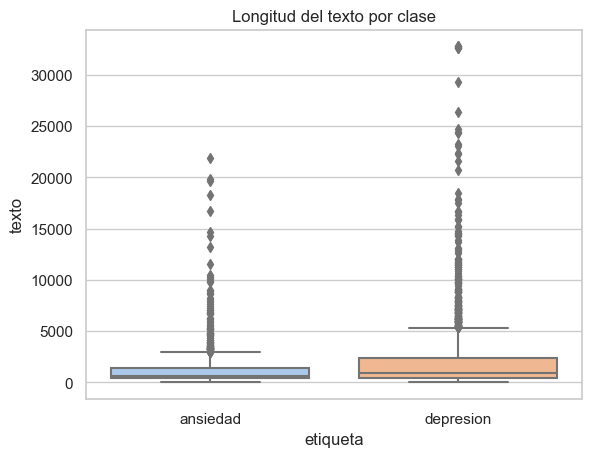

In [121]:
# ---------------------------------------------------------------
# Verificación post-limpieza
# ---------------------------------------------------------------
print("Distribución de clases:")
print(df_final['etiqueta'].value_counts())

sns.boxplot(data=df_final, x='etiqueta', y=df_final['texto'].str.len())
plt.title("Longitud del texto por clase")
plt.show()


## Exportar dataset limpio para baselines

In [122]:
# ---------------------------------------------------------------
# Exportar ips_clean.csv para uso en baselines
# ---------------------------------------------------------------
# Este dataset limpio será el INPUT para 02_create_splits.ipynb
# Garantiza que todos los baselines partan del mismo dataset sin duplicados

CLEAN_FILE = DATA_PATH / "ips_clean.csv"
df_final.to_csv(CLEAN_FILE, index=False, encoding='utf-8')

print(f"[OK] Dataset limpio exportado: {CLEAN_FILE}")
print(f" Filas originales: {len(df_raw)}")
print(f" Duplicados eliminados: {duplicates.sum()}")
print(f" Filas finales: {len(df_final)}")
print(f"\n Distribución final:")
print(df_final['etiqueta'].value_counts())
print(f"\n Este archivo será usado por 02_create_splits.ipynb")

[OK] Dataset limpio exportado: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/ips_clean.csv
 Filas originales: 3155
 Duplicados eliminados: 28
 Filas finales: 3127

 Distribución final:
etiqueta
depresion    2202
ansiedad      925
Name: count, dtype: int64

 Este archivo será usado por 02_create_splits.ipynb


In [123]:
## Top n-grama
from collections import Counter

def ngrams(tokens, n):
 return zip(*[tokens[i:] for i in range(n)])

def top_ngrams(texts, n=1, topk=30):
    counter = Counter()
    for t in texts:
        toks = re.findall(r"[a-záéíóúüñ]+", str(t).lower())
    for ng in ngrams(toks, n):
        counter[" ".join(ng)] += 1
    return counter.most_common(topk)

texts_all = df_raw[text_col].astype(str).tolist()

uni = top_ngrams(texts_all, n=1, topk=40)
bi = top_ngrams(texts_all, n=2, topk=40)
tri = top_ngrams(texts_all, n=3, topk=30)

pd.DataFrame(uni, columns=["unigram","freq"]).to_csv(DATA_PATH/"eda_top_unigrams.csv", index=False, encoding="utf-8")
pd.DataFrame(bi, columns=["bigram","freq"]).to_csv(DATA_PATH/"eda_top_bigrams.csv", index=False, encoding="utf-8")
pd.DataFrame(tri, columns=["trigram","freq"]).to_csv(DATA_PATH/"eda_top_trigrams.csv", index=False, encoding="utf-8")
print(" eda_top_unigrams.csv | eda_top_bigrams.csv | eda_top_trigrams.csv")

display(pd.DataFrame(uni[:15], columns=["unigram","freq"]))
display(pd.DataFrame(bi[:15], columns=["bigram","freq"]))
display(pd.DataFrame(tri[:15], columns=["trigram","freq"]))


 eda_top_unigrams.csv | eda_top_bigrams.csv | eda_top_trigrams.csv


,unigram,freq
0,con,12
1,en,7
2,tratamiento,7
3,de,7
4,paciente,4
5,previo,4
6,la,4
7,dra,4
8,rendon,4
9,dx,4


,bigram,freq
0,paciente en,4
1,en tratamiento,4
2,tratamiento previo,4
3,previo con,4
4,con la,4
5,la dra,4
6,dra rendon,4
7,rendon con,4
8,con dx,4
9,dx de,4


,trigram,freq
0,paciente en tratamiento,4
1,en tratamiento previo,4
2,tratamiento previo con,4
3,previo con la,4
4,con la dra,4
5,la dra rendon,4
6,dra rendon con,4
7,rendon con dx,4
8,con dx de,4
9,dx de f,4


In [124]:
## Wordcloud
from wordcloud import WordCloud
text_blob = " ".join(df_final['texto'].astype(str).tolist())
wc = WordCloud(width=1000, height=600, background_color="white").generate(text_blob)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.imshow(wc)
plt.axis("off")
plt.tight_layout()
plt.savefig(FIGS_PATH/"eda_wordcloud.png", dpi=160)
plt.close()
print("[OK] Nube guardada:", FIGS_PATH/"eda_wordcloud.png")


[OK] Nube guardada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/eda_wordcloud.png


In [125]:
import unicodedata, numpy as np, pandas as pd, re
import matplotlib.pyplot as plt
from pathlib import Path

def pct_diacritics(s: str) -> float:
 if not s: return 0.0
 vowels = sum(ch.lower() in "aeiou" for ch in s)
 acc = sum(ch.lower() in "áéíóúü" for ch in s)
 return (acc / vowels) if vowels else 0.0

def pct_digits(s: str) -> float:
 if not s: return 0.0
 cnt = sum(ch.isdigit() for ch in s)
 return cnt / max(1, len(s))

def pct_punct(s: str) -> float:
 if not s: return 0.0
 cnt = sum(ch in r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~""" for ch in s)
 return cnt / max(1, len(s))

def pct_elongations(s: str) -> float:
 if not s: return 0.0
 # proporción de caracteres que forman parte de alargamientos colapsables
 matches = re.findall(r'(.)\1{2,}', s)
 # conteo simple: cantidad de runs de elongación / longitud
 return (len(matches) / max(1, len(s)))

LABEL_COL = 'etiqueta'

txt = df_final['texto'].astype(str)
eda_noise = pd.DataFrame({
 "len_text": txt.str.len(),
 "len_tokens_approx": txt.str.split().map(len),
 "pct_diacritics": txt.map(pct_diacritics),
 "pct_digits": txt.map(pct_digits),
 "pct_punct": txt.map(pct_punct),
 "pct_elong": txt.map(pct_elongations),
})

if LABEL_COL is not None:
 eda_noise[LABEL_COL] = df_final[LABEL_COL].values

eda_noise.describe().to_csv(DATA_PATH/"eda_noise_stats_overall.csv", encoding="utf-8")
print(" Guardado: eda_noise_stats_overall.csv")

if LABEL_COL is not None:
    grp = eda_noise.groupby(LABEL_COL).agg(["mean","median","std"])
    grp.to_csv(DATA_PATH/"eda_noise_stats_by_class.csv", encoding="utf-8")
    print(" Guardado: eda_noise_stats_by_class.csv")
    display(grp)
else:
    display(eda_noise.describe())


 Guardado: eda_noise_stats_overall.csv
 Guardado: eda_noise_stats_by_class.csv


len_text                     len_tokens_approx         \
                  mean median          std              mean median   
etiqueta                                                              
ansiedad   1388.060541  627.0  2153.249903        230.123243   99.0   
depresion  2085.445050  891.5  3254.221341        350.306540  150.0   

                      pct_diacritics                     pct_digits            \
                  std           mean    median       std       mean    median   
etiqueta                                                                        
ansiedad   355.691768       0.010545  0.007463  0.012721   0.043682  0.044239   
depresion  553.408020       0.013509  0.007634  0.016170   0.058908  0.068182   

                    pct_punct                     pct_elong              
                std      mean    median       std      mean median  std  
etiqueta                                                                 
ansiedad   0.035670  0.058450  0.051081  0.030013       0.0    0.0  0.0  
depresion  0.032744  0.068218  0.071795  0.027612       0.0    0.0  0.0

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
if LABEL_COL is not None:
    sns.boxplot(data=eda_noise, x=LABEL_COL, y="len_text")
    plt.title("Longitud de texto por clase (caracteres)")
    plt.tight_layout(); plt.savefig(FIGS_PATH/"eda_len_text_by_class.png", dpi=160); plt.close()

    plt.figure(figsize=(7,4))
    sns.boxplot(data=eda_noise, x=LABEL_COL, y="len_tokens_approx")
    plt.title("Longitud de texto por clase (tokens aprox.)")
    plt.tight_layout(); plt.savefig(FIGS_PATH/"eda_len_tokens_by_class.png", dpi=160); plt.close()
    print("[OK] Guardadas figuras de longitud por clase.")
else:
    print("[WARNING] No hay etiqueta. Se omiten boxplots por clase.")


[OK] Guardadas figuras de longitud por clase.


In [127]:
from collections import Counter

def top_ngrams_for_mask(texts, mask, n=1, topk=25):
 counter = Counter()
 for t, m in zip(texts, mask):
    if not m: continue
    toks = re.findall(r"[a-záéíóúüñ]+", str(t).lower())
    for i in range(len(toks)-(n-1)):
        ng = " ".join(toks[i:i+n])
        counter[ng] += 1
 return counter.most_common(topk)

if LABEL_COL is not None:
    mask_dep = (df_final[LABEL_COL]=="depresion").fillna(False).values
    mask_ans = (df_final[LABEL_COL]=="ansiedad").fillna(False).values
    texts_all = df_final['texto'].astype(str).tolist()

    uni_dep = top_ngrams_for_mask(texts_all, mask_dep, n=1, topk=30)
    uni_ans = top_ngrams_for_mask(texts_all, mask_ans, n=1, topk=30)
    bi_dep = top_ngrams_for_mask(texts_all, mask_dep, n=2, topk=30)
    bi_ans = top_ngrams_for_mask(texts_all, mask_ans, n=2, topk=30)

    pd.DataFrame(uni_dep, columns=["unigram","freq"]).to_csv(DATA_PATH/"eda_dep_unigrams.csv", index=False)
    pd.DataFrame(uni_ans, columns=["unigram","freq"]).to_csv(DATA_PATH/"eda_ans_unigrams.csv", index=False)
    pd.DataFrame(bi_dep, columns=["bigram","freq"]).to_csv(DATA_PATH/"eda_dep_bigrams.csv", index=False)
    pd.DataFrame(bi_ans, columns=["bigram","freq"]).to_csv(DATA_PATH/"eda_ans_bigrams.csv", index=False)
    print(" Export por clase: eda_dep/ans_unigrams.csv, eda_dep/ans_bigrams.csv")
else:
    print("[WARNING] No hay etiqueta. Se omiten n-gramas por clase.")


 Export por clase: eda_dep/ans_unigrams.csv, eda_dep/ans_bigrams.csv
